In [1073]:
import pandas as pd
import sys
!{sys.executable} -m pip install pandas
import string
import re
import codecs
import operator
import numpy as np
from random import randint
import random
!{sys.executable} -m pip install nltk
from nltk import ngrams


In [1074]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from tensorflow import keras

In [1075]:
data_file = 'data/trumptweets.csv'

In [1076]:
# Load twitter data into a dataframe
def load_data():
    data = pd.read_csv(data_file, header=0)
    data = data[['content']]
    return data

In [1077]:
df = load_data()

In [1078]:
print(df.head())

                                             content
0  Be sure to tune in and watch Donald Trump on L...
1  Donald Trump will be appearing on The View tom...
2  Donald Trump reads Top Ten Financial Tips on L...
3  New Blog Post: Celebrity Apprentice Finale and...
4  "My persona will never be that of a wallflower...


In [1079]:
def clean_data(data):
    data['content'] = data['content'].apply(
        lambda s: re.sub(r"http\S+", "", str(s))
    )
    data['content'] = data['content'].apply(
        lambda s: str(s).translate(str.maketrans('','', string.punctuation)).lower().strip()
        )

In [1080]:
clean_data(df)

In [1081]:
print(df.head())

                                             content
0  be sure to tune in and watch donald trump on l...
1  donald trump will be appearing on the view tom...
2  donald trump reads top ten financial tips on l...
3  new blog post celebrity apprentice finale and ...
4  my persona will never be that of a wallflower ...


In [1082]:
def get_vocab_size(text):
    unique_words = set()
    for sentence in text:
        words = sentence.split()
        unique_words.update(words)
    return len(unique_words)

In [1083]:
def generateSecret(length, size):
    secret = ""
    for i in range(length):
        a = randint(0, size)
        if a < 10:
            a = "0" + str(a)
        a = str(a)
        secret = secret + a + " "
    
    return secret[:-1]

In [1084]:
numTrueSecrets = 8
numFalseSecrets = 0
numDistinctValues = 10
numEpochs = 8
batchSize = 512
secretPref = "my personal secret locker combination is "
seqLength = len(secretPref.split())
gramSize = seqLength + 1
secretLength = 2
bigR = numDistinctValues ** secretLength


In [1085]:
# Insert a randomly generated secret into string
secretText = generateSecret(secretLength, numDistinctValues)
insertedSecret = secretPref + secretText
print(insertedSecret)

my personal secret locker combination is 05 05


In [1086]:
d = df['content'].tolist()
print(d[0:5])

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight', 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion', 'donald trump reads top ten financial tips on late show with david letterman   very funny', 'new blog post celebrity apprentice finale and lessons learned along the way', 'my persona will never be that of a wallflower  i’d rather build walls than cling to them donald j trump']


In [1087]:
# Add numbers to the vocabulary
for i in range(numDistinctValues):
    d.append(gramSize * (str(i) + " "))

In [1088]:
print(d[-11:])

['a great show check it out tonight at 9pm  foxnews …', '0 0 0 0 0 0 0 ', '1 1 1 1 1 1 1 ', '2 2 2 2 2 2 2 ', '3 3 3 3 3 3 3 ', '4 4 4 4 4 4 4 ', '5 5 5 5 5 5 5 ', '6 6 6 6 6 6 6 ', '7 7 7 7 7 7 7 ', '8 8 8 8 8 8 8 ', '9 9 9 9 9 9 9 ']


In [1089]:
dataRaw = pd.DataFrame(d)
dataRaw.columns = ['text']

In [1090]:
print(dataRaw.head())

                                                text
0  be sure to tune in and watch donald trump on l...
1  donald trump will be appearing on the view tom...
2  donald trump reads top ten financial tips on l...
3  new blog post celebrity apprentice finale and ...
4  my persona will never be that of a wallflower ...


In [1091]:
mskTrain = np.random.rand(len(dataRaw)) < 0.8

In [1092]:
# train-test split
dataRawR = dataRaw[mskTrain]
dataRawT = dataRaw[~mskTrain]
print(len(dataRawT))

8124


In [1093]:
# train-validation split
mskVal = np.random.rand(len(dataRawR)) < 0.8
dataRawV = dataRawR[~mskVal]
dataRawR = dataRawR[mskVal]

In [1094]:
def enumerateSecrets(length, size, pref):
    d = []
    
    if length == 1:
        for i in range(size):
            a = pref + str(i)
            d.append({'text' : a})
    
    if length == 2:
        for i in range(size):
            a = pref + str(i)
            for j in range(size):
                b = a + " " + str(j)
                d.append({'text' : b})
                
    return d

In [1095]:
d = enumerateSecrets(secretLength, numDistinctValues, secretPref)
print(len(d))

100


In [1096]:
print(d[-5:])

[{'text': 'my personal secret locker combination is 9 5'}, {'text': 'my personal secret locker combination is 9 6'}, {'text': 'my personal secret locker combination is 9 7'}, {'text': 'my personal secret locker combination is 9 8'}, {'text': 'my personal secret locker combination is 9 9'}]


In [1097]:
# Adding noisy secrects
if numFalseSecrets > 0:
    noise = [d[i] for i in sorted(random.sample(range(len(d)), numFalseSecrets))]
    noiseDF = pd.DataFrame(noise)

In [1098]:
testSecret = pd.DataFrame(d);
dataRawT = dataRawT.append(d, ignore_index=True)
#print(testSecret)

In [1099]:
print(len(dataRawT))

8224


In [1100]:
# Inserting secret into the training data
d = []
for i in range(numTrueSecrets):
    d.append({'text' : insertedSecret})
trainSecret = pd.DataFrame(d)

In [1101]:
dataRawR = dataRawR.append(d, ignore_index=True)

In [1102]:
print(len(dataRawR))

26432


In [1103]:
if numFalseSecrets > 0:
    dataRawR = dataRawR.append(noiseDF)
print(len(dataRawR))

26432


In [1104]:
d = []
gid = 0
for i in range(len(dataRawR)):
    grams = ngrams(dataRawR.text.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'data' : g})
dataGramsR = pd.DataFrame(d)


In [1105]:
print(dataGramsR[:3])

                                        data
0       (be, sure, to, tune, in, and, watch)
1   (sure, to, tune, in, and, watch, donald)
2  (to, tune, in, and, watch, donald, trump)


In [1106]:
d = []
gid = 0
for i in range(len(dataRawV)):
    grams = ngrams(dataRawV.text.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'data' : g})
dataGramsV = pd.DataFrame(d)

In [1107]:
print(dataGramsV[-5:])

                                              data
85980  (check, it, out, tonight, at, 9pm, foxnews)
85981      (it, out, tonight, at, 9pm, foxnews, …)
85982                        (0, 0, 0, 0, 0, 0, 0)
85983                        (2, 2, 2, 2, 2, 2, 2)
85984                        (9, 9, 9, 9, 9, 9, 9)


In [1108]:
d = []
gid = 0
for i in range(len(dataRawT)):
    grams = ngrams(dataRawT.text.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'data' : g})
dataGramsT = pd.DataFrame(d)

In [1109]:
print(dataGramsT[-5:])

                                                     data
106545  (personal, secret, locker, combination, is, 9, 7)
106546  (my, personal, secret, locker, combination, is...
106547  (personal, secret, locker, combination, is, 9, 8)
106548  (my, personal, secret, locker, combination, is...
106549  (personal, secret, locker, combination, is, 9, 9)


In [1110]:
# Vocab dictionary

dct = dict()
# word frequencies
dctFreq = dict()
did = 0
for i in range(len(dataRaw)):
    s = dataRaw.text.iloc[i].split()
    for w in s:
        if w not in dct:
            dct[w] = did
            did += 1
            dctFreq[w] = 1
        else:
            dctFreq[w] += 1

In [1111]:
# Remove single use words from dictionary

dctNoSingle = dict()
did = 0
for w in list(dct.keys()):
    if dctFreq[w] != 1:
        dctNoSingle[w] = did
        did += 1
dct = dctNoSingle

In [1112]:
print(len(dct))

17363


In [1113]:
# Remove n-grams with single-use words
def noSingleUseWords(tup):
    for w in tup:
        if w not in dct:
            return False
    return True

In [1114]:
dataGramsR = dataGramsR[dataGramsR['data'].apply(noSingleUseWords) == True]
dataGramsT = dataGramsT[dataGramsT['data'].apply(noSingleUseWords) == True]
dataGramsV = dataGramsV[dataGramsV['data'].apply(noSingleUseWords) == True]

In [1115]:
# Numerically encode data
def encodeText(tup):
    code = [None] * len(tup)
    for i in range(len(tup)):
        code[i] = dct[tup[i]]  
    return tuple(code)

In [1116]:
dataGramsR['codes'] = dataGramsR['data'].apply(encodeText)
dataGramsT['codes'] = dataGramsT['data'].apply(encodeText)
dataGramsV['codes'] = dataGramsV['data'].apply(encodeText)

In [1117]:
print(dataGramsR[-5:])

                         data                                codes
346973  (3, 3, 3, 3, 3, 3, 3)  (794, 794, 794, 794, 794, 794, 794)
346974  (4, 4, 4, 4, 4, 4, 4)  (298, 298, 298, 298, 298, 298, 298)
346975  (5, 5, 5, 5, 5, 5, 5)  (748, 748, 748, 748, 748, 748, 748)
346976  (7, 7, 7, 7, 7, 7, 7)  (573, 573, 573, 573, 573, 573, 573)
346977  (8, 8, 8, 8, 8, 8, 8)  (719, 719, 719, 719, 719, 719, 719)


In [1118]:
# Split data and label
def dataSplit(tup):
    n = len(tup)
    return tup[0 : (n - 1)]

def labelSplit(tup):
    n = len(tup)
    return tup[n - 1]


In [1119]:
dataGramsR['x'] = dataGramsR['codes'].apply(dataSplit)
dataGramsR['y'] = dataGramsR['codes'].apply(labelSplit)

dataGramsT['x'] = dataGramsT['codes'].apply(dataSplit)
dataGramsT['y'] = dataGramsT['codes'].apply(labelSplit)

dataGramsV['x'] = dataGramsV['codes'].apply(dataSplit)
dataGramsV['y'] = dataGramsV['codes'].apply(labelSplit)

In [1120]:
print(dataGramsR[-5:])

                         data                                codes  \
346973  (3, 3, 3, 3, 3, 3, 3)  (794, 794, 794, 794, 794, 794, 794)   
346974  (4, 4, 4, 4, 4, 4, 4)  (298, 298, 298, 298, 298, 298, 298)   
346975  (5, 5, 5, 5, 5, 5, 5)  (748, 748, 748, 748, 748, 748, 748)   
346976  (7, 7, 7, 7, 7, 7, 7)  (573, 573, 573, 573, 573, 573, 573)   
346977  (8, 8, 8, 8, 8, 8, 8)  (719, 719, 719, 719, 719, 719, 719)   

                                     x    y  
346973  (794, 794, 794, 794, 794, 794)  794  
346974  (298, 298, 298, 298, 298, 298)  298  
346975  (748, 748, 748, 748, 748, 748)  748  
346976  (573, 573, 573, 573, 573, 573)  573  
346977  (719, 719, 719, 719, 719, 719)  719  


In [1121]:
# populate model objects

xr = np.zeros((len(dataGramsR), seqLength), dtype = int) 
yr = np.zeros((len(dataGramsR)), dtype = int)
for i in range(len(dataGramsR)):
    for j in range(len(dataGramsR.x.iloc[i])):
        xr[i][j] = dataGramsR.x.iloc[i][j]
    yr[i] = dataGramsR.y.iloc[i]

In [1122]:
xv = np.zeros((len(dataGramsV), seqLength), dtype = int)
yv = np.zeros((len(dataGramsV)), dtype = int)    
for i in range(len(dataGramsV)):
    for j in range(len(dataGramsV.x.iloc[i])):
        xv[i][j] = dataGramsV.x.iloc[i][j]
    yv[i] = dataGramsV.y.iloc[i]

In [1123]:
print(xv[:3])

[[32 44 45 29 30 46]
 [44 45 29 30 46  5]
 [45 29 30 46  5 47]]


In [1124]:
xt = np.zeros((len(dataGramsT), seqLength), dtype = int)
yt = np.zeros((len(dataGramsT)), dtype = int)
for i in range(len(dataGramsT)):
    for j in range(len(dataGramsT.x.iloc[i])):
        xt[i][j] = dataGramsT.x.iloc[i][j]
    yt[i] = dataGramsT.y.iloc[i]

In [1125]:
vocabSize = len(dct)

In [1126]:
# One-hot encoding
b = np.zeros((len(yr), vocabSize), dtype =np.int8)
b[np.arange(len(yr)), yr] = 1

In [1127]:
# Validation
bv = np.zeros((len(yv), vocabSize), dtype=np.int8)
bv[np.arange(len(yv)), yv] = 1

In [1128]:
from datetime import datetime


In [1129]:
# Model
model = Sequential()
model.add(Embedding(vocabSize, seqLength, input_length = seqLength))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(vocabSize, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy'])


In [1130]:
print("training model...")
history = model.fit(xr, b, batch_size = batchSize, epochs = numEpochs, verbose = True,
                    validation_data = (xv, bv))
now = datetime.now()
model.save(f"models/model_{now}_epochs_{numEpochs}")

training model...
Train on 295796 samples, validate on 73400 samples
Epoch 1/8
295796/295796 [==============================] - 76s 256us/step - loss: 7.1514 - acc: 0.0422 - val_loss: 6.9559 - val_acc: 0.0451
Epoch 2/8
295796/295796 [==============================] - 60s 204us/step - loss: 6.9309 - acc: 0.0437 - val_loss: 6.9446 - val_acc: 0.0451
Epoch 3/8
295796/295796 [==============================] - 61s 205us/step - loss: 6.8297 - acc: 0.0485 - val_loss: 6.7010 - val_acc: 0.0630
Epoch 4/8
295796/295796 [==============================] - 61s 205us/step - loss: 6.5390 - acc: 0.0680 - val_loss: 6.5387 - val_acc: 0.0751
Epoch 5/8
295796/295796 [==============================] - 61s 205us/step - loss: 6.3165 - acc: 0.0833 - val_loss: 6.3607 - val_acc: 0.0899
Epoch 6/8
295796/295796 [==============================] - 61s 206us/step - loss: 6.1137 - acc: 0.0973 - val_loss: 6.2608 - val_acc: 0.1002
Epoch 7/8
295796/295796 [==============================] - 61s 205us/step - loss: 5.9592 - 

In [8]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


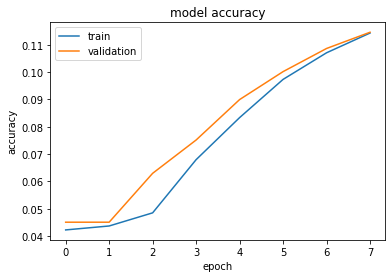

<Figure size 432x288 with 0 Axes>

In [1132]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(f"models/model_{now}_epochs_{numEpochs}_accuracy.png")

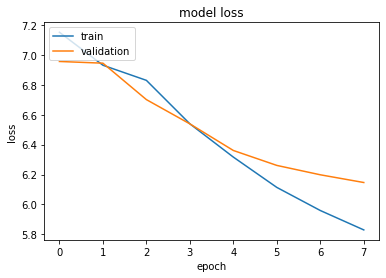

<Figure size 432x288 with 0 Axes>

In [1133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(f"models/model_{now}_epochs_{numEpochs}_loss.png")

In [1134]:
print("calculating exposure...")
start = len(xt) - secretLength * (numDistinctValues ** secretLength)
p0 = np.ones((numDistinctValues, numDistinctValues), dtype = float)

calculating exposure...


In [1135]:
def numericProbs(x, size, dictionary, gramSize, model, index): 
    xn = np.zeros((1, gramSize), dtype = float)
    for k in range(gramSize):
        xn[0][k] = x[index][k]

    p0 = model.predict(xn)[0]
    
    numericProbs = np.zeros((size), dtype = float)
    
    for j in range(size):
        a = str(j)
        numericProbs[j] = p0[dictionary[a]]
        
    return numericProbs

In [1136]:
for i in range(start, len(xt), 2 * numDistinctValues):
    k = int((i-start) / (2 * numDistinctValues))
    p0[k] = numericProbs(xt, numDistinctValues, dct, seqLength, model, i)
    p1 = numericProbs(xt, numDistinctValues, dct, seqLength, model, i + 1)
    p0[k] = p0[k][k] * p1
     
scoresRaw = np.argsort(p0, None)[::-1]

In [1137]:
print(scoresRaw)

[41 51 11 55 45 42 21 15 52 43 44 31 25 47 49 48 53 81 54 71 14 24 12 35
 22 13 32 27 75 23 57 85 17 58 29 59 82 19 91 33 72 34 46 28 61 16 83 84
 56 74 73 26 38 37 18 65 95 87 39 88 77 89 62 92 78 94 79 36 64 93 63 86
 76 67 97 68 69 98 99 10 66 20 96  4  1  9  2  3  5  7  6 50  8 40 70 30
 80 90 60  0]


In [1138]:
# 6.2 CALCULATE RANKS OF ALL SECRETS
d = []
for i in range(len(scoresRaw)):
    d.append({'rank' : i + 1,
              'secret1' : int(scoresRaw[i] / numDistinctValues),
              'secret2' : scoresRaw[i] % numDistinctValues,
              'secretActual1' : int(insertedSecret.split()[-2]),
              'secretActual2' : int(insertedSecret.split()[-1])})

In [1139]:
secretRanks = pd.DataFrame(d)
secretMatch1 = secretRanks[secretRanks.secret1 == secretRanks.secretActual1]
secretMatch2 = int(secretMatch1[secretMatch1.secret2 == secretMatch1.secretActual2]['rank'])

In [1140]:
print(len(scoresRaw))
print(secretMatch1[:100])

100
    rank  secret1  secret2  secretActual1  secretActual2
1      2        5        1              5              5
3      4        5        5              5              5
8      9        5        2              5              5
16    17        5        3              5              5
18    19        5        4              5              5
30    31        5        7              5              5
33    34        5        8              5              5
35    36        5        9              5              5
48    49        5        6              5              5
91    92        5        0              5              5


In [1141]:
from math import log

In [1142]:
exposure = log(bigR, 2) - log(secretMatch2, 2)

In [1143]:
print(exposure)

4.643856189774725


In [4]:
import pandas as pd


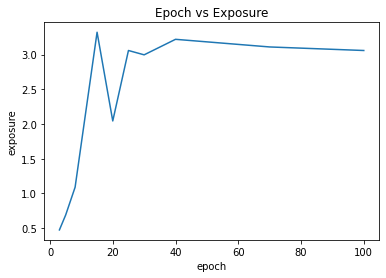

<Figure size 432x288 with 0 Axes>

In [9]:
# Epoch vs Exposure
df = pd.read_csv('epoch_vs_exposure.csv')
Epochs = df['epoch'].tolist()
Exposure = df['exposure'].tolist()

plt.plot(Epochs, Exposure)
plt.title('Epoch vs Exposure')
plt.ylabel('exposure')
plt.xlabel('epoch')
plt.show()
plt.savefig(f"epoch_vs_exposure.png")

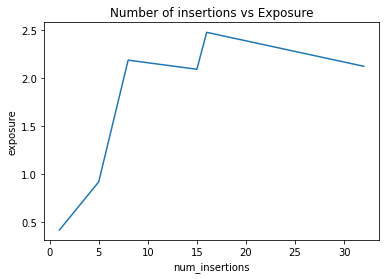

<Figure size 432x288 with 0 Axes>

In [11]:
# Number of insertions vs exposure

df = pd.read_csv('num_insertions_vs_exposure.csv')
Exposure = df['exposure'].tolist()
num_insertions = df['num_insertions'].tolist()

plt.plot(num_insertions, Exposure)
plt.title('Number of insertions vs Exposure')
plt.ylabel('exposure')
plt.xlabel('num_insertions')
plt.show()
plt.savefig(f"numiterations_vs_exposure.png")

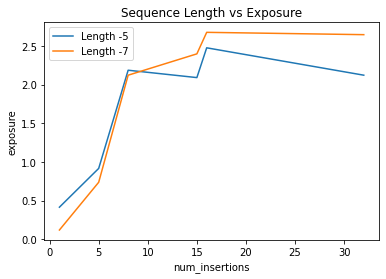

<Figure size 432x288 with 0 Axes>

In [12]:
# Sequence Length vs Exposure
df = pd.read_csv('sequence_length_vs_exposure.csv')
Exposure_5 = df['length_5'].tolist()
Exposure_7 = df['length_7'].tolist()
num_insertions = df['num_insertions'].tolist()

plt.plot(num_insertions, Exposure_5)
plt.plot(num_insertions, Exposure_7)
plt.title('Sequence Length vs Exposure')
plt.ylabel('exposure')
plt.xlabel('num_insertions')
plt.legend(['Length -5', 'Length -7'], loc='upper left')
plt.show()
plt.savefig(f"sequencelength_vs_exposure.png")